In [1]:
import tensorflow as tf
import os
from bing_image_downloader import downloader
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

import random
np.set_printoptions(suppress=True)

In [2]:
# downloader.download("Hagia Sophia — Istanbul, Turkey", limit=250, output_dir="images")
# downloader.download("Dancing House — Prague, Czech Republic", limit=250, output_dir="images")
# downloader.download("Château de Chenonceau — Chenonceaux, France", limit=250, output_dir="images")
# downloader.download("The Colosseum — Rome, Italy", limit=250, output_dir="images")
# downloader.download("St. Basil’s Cathedral — Moscow, Russia", limit=250, output_dir="images")
# downloader.download("Avalski toranj", limit=250, output_dir="images")

In [3]:
data_dir = "images"
image_exts = ["jpeg", "jpg", "bmp", "png"]

In [4]:
# os.listdir(data_dir)

In [5]:
# os.listdir(os.path.join(data_dir,"Chateau de Chenonceau"))

In [6]:
# img = cv2.imread(os.path.join(data_dir, "Chateau de Chenonceau", "Image_10.jpg"))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
# img.shape

In [7]:
data = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,   
)
data

Found 628 files belonging to 5 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [8]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [9]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [10]:
batch = data_iterator.next()
len(batch)
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32, 5))

In [11]:
# fig, ax = plt.subplots(ncols=10, figsize=(20,20))
# for idx, img in enumerate(batch[0][:10]):
#   ax[idx].imshow(img.astype(int))
#   ax[idx].title.set_text(batch[1][idx])

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    validation_split=0.3,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,
)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    validation_split=0.3,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,   
)
tf.data.experimental.cardinality(val_test_ds).numpy()

Found 628 files belonging to 5 classes.


Using 440 files for training.
Found 628 files belonging to 5 classes.
Using 188 files for validation.


6

In [13]:
total_samples = val_test_ds.cardinality().numpy()
val_num = int(0.7*total_samples)
test_num = int(0.3*total_samples)
val_num, test_num

(4, 1)

In [14]:
val_ds = val_test_ds.take(val_num)
test_ds = val_test_ds.skip(val_num).take(test_num)
val_ds, test_ds

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [15]:
# ucitaj sve podatke u jedan dataset
# 30% podataka rasporedi u drugi dataset tako da imaju jednak broj iz svake klase
# 30 slika iz svake klase uzmi i smesti u novi dataset
main_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,
)

images_count_val = [0,0,0,0,0]
images_count_test = [0,0,0,0,0]

val__images = []
val__labels = []

test_images = []
test_labels = []

train_images = []
train_labels = []

for image,label in main_ds.unbatch():

    if images_count_test[np.argmax(label.numpy())] < 85:
        train_images.append(image)
        train_labels.append(label)
        images_count_test[np.argmax(label.numpy())] = images_count_test[np.argmax(label.numpy())] + 1

    elif images_count_val[np.argmax(label.numpy())] < 15:
        val__images.append(image)
        val__labels.append(label)
        images_count_val[np.argmax(label.numpy())] = images_count_val[np.argmax(label.numpy())] + 1
    
    else:
        test_images.append(image)
        test_labels.append(label)

train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds_balanced = train_ds_balanced.shuffle(100)
train_ds_balanced = train_ds_balanced.batch(32)

val_ds_balanced = tf.data.Dataset.from_tensor_slices((val__images, val__labels))
val_ds_balanced = val_ds_balanced.shuffle(100)
val_ds_balanced = val_ds_balanced.batch(32)

test_ds_balanced = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds_balanced = test_ds_balanced.shuffle(100)
test_ds_balanced = test_ds_balanced.batch(32)

train_ds_balanced

Found 628 files belonging to 5 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [16]:
import tensorflow as tf

class_counts = {}

for _, labels in val_ds_balanced:
    for label in labels.numpy():
        class_idx = label.argmax()  
        if class_idx not in class_counts:
            class_counts[class_idx] = 1
        else:
            class_counts[class_idx] += 1

for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")


Class 0: 15 samples
Class 2: 15 samples
Class 3: 15 samples
Class 1: 15 samples
Class 4: 15 samples


In [17]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # RandomFlip layer
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)
        ),  # RandomTranslation layer
        tf.keras.layers.RandomRotation(factor=0.2),  # RandomRotation layer
        # tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3)),  # RandomZoom layer
        tf.keras.layers.RandomContrast(factor=(0.2)),  # RandomContrast layer
        tf.keras.layers.RandomBrightness(factor=(0.2)),  # RandomBrightness layer
    ]
)
AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented2 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented3 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented4 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)

In [18]:
# import numpy as np
# import tensorflow as tf

# target_class_size = 350
# classes_count = [0, 0, 0, 0, 0, 0]

# augmented_X = []
# augmented_Y = []

# # racunamo koliko slika fali za svaku klasu
# for batch_X, batch_y in train_ds.unbatch():
#     classes_count[np.argmax(batch_y)] = classes_count[np.argmax(batch_y)] + 1
# for x in classes_count:
#     print(x)


# def apply_augmentation(image, label):
#     # class_index = np.argmax(label)4
#     print(label)

#     if classes_count[np.argmax(label)] < target_class_size:
#         augmented_image = data_augmentation(image, training=True)
#         return augmented_image, label
#     else:
#         return image, label


# train_ds_augmented = train_ds.map(apply_augmentation, num_parallel_calls=AUTOTUNE)

# for batch_X, batch_y in train_ds_augmented.unbatch():
#     class_index = np.argmax(batch_y)
#     classes_count[class_index] += 1

In [19]:
train_ds_merged = train_ds_balanced.concatenate(train_ds_augmented)
train_ds_merged = train_ds_merged.concatenate(train_ds_augmented2)
# train_ds_merged = train_ds_merged.concatenate(train_ds_augmented3)
# train_ds_merged = train_ds_merged.concatenate(train_ds_augmented4)

train_ds_merged

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [20]:
from sklearn.utils.class_weight import compute_class_weight

classes = [0, 1, 2, 3, 4]
y = np.array([label.numpy() for _, label in train_ds_merged.unbatch()])
y = np.argmax(y, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights

array([1., 1., 1., 1., 1.])

In [21]:
class_weights_dict = {}
for i, weight in enumerate(class_weights):
    class_weights_dict[i] = weight
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

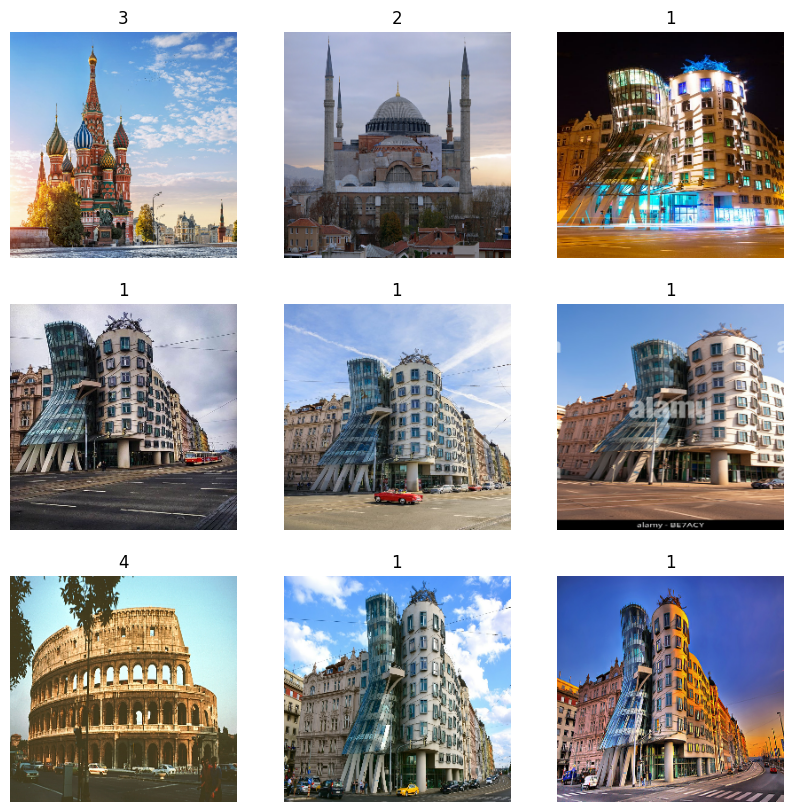

In [22]:
class_names = [0,1,2,3,4]
plt.figure(figsize=(10, 10))
for images, labels in train_ds_merged.take(4):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy()) #
        plt.title(class_names[int(label_index)])  
        plt.axis("off")

In [23]:
train_ds_merged = train_ds_merged.map(lambda x, y: (x/255, y))
val_ds_balanced = val_ds_balanced.map(lambda x, y: (x/255, y))
test_ds_balanced = test_ds_balanced.map(lambda x, y: (x/255, y))

sample = val_ds_balanced.as_numpy_iterator().next()
sample[0].max()

for batch in train_ds_merged:
    print(batch)


(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.8274357 , 0.81567097, 0.74116117],
         [0.8313419 , 0.8195772 , 0.7450674 ],
         [0.83221173, 0.820447  , 0.7459372 ],
         ...,
         [0.8156863 , 0.8235294 , 0.76862746],
         [0.82144606, 0.8292892 , 0.77438724],
         [0.82743806, 0.83920276, 0.7725361 ]],

        [[0.8156791 , 0.80391437, 0.72940457],
         [0.8156863 , 0.8039216 , 0.7294118 ],
         [0.8147265 , 0.81083506, 0.7323936 ],
         ...,
         [0.81087095, 0.8187141 , 0.7638121 ],
         [0.81747854, 0.8253217 , 0.7704197 ],
         [0.8195231 , 0.8312878 , 0.76462114]],

        [[0.8031676 , 0.79155606, 0.71712285],
         [0.81549716, 0.80388564, 0.72945243],
         [0.7944824 , 0.79311764, 0.7139984 ],
         ...,
         [0.80683213, 0.81482846, 0.7599265 ],
         [0.8097628 , 0.8174527 , 0.76270396],
         [0.80798435, 0.8195193 , 0.7532356 ]],

        ...,

        [[0.16663028, 0.17914896

In [24]:
model = Sequential()

model.add(Conv2D(16, 7, activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))  

model.add(Conv2D(32, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))  

model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))  

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))  

model.add(Dense(units=5, activation="softmax"))

In [25]:
model.compile("adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [26]:
# model.summary()

In [27]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# callbacks = [
#         EarlyStopping(patience=10, monitor="val_loss", verbose=1),
#         TensorBoard(log_dir="logs", histogram_freq=1),
#     ]
# hist = model.fit(train_ds_merged, epochs=100, validation_data=val_ds_balanced, class_weight=class_weights_dict, callbacks=callbacks)
model.load_weights('./checkpoints/my_checkpoint')

In [28]:
# fig = plt.figure()
# plt.plot(hist.history["accuracy"], color="green", label="Acc")
# plt.plot(hist.history["val_accuracy"], color="orange", label="val_acc")
# fig.suptitle("Accuracy", fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

In [29]:
# fig = plt.figure()
# plt.plot(hist.history["loss"], color="green", label="Acc")
# plt.plot(hist.history["val_loss"], color="orange", label="val_acc")
# fig.suptitle("Loss", fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

In [30]:
# model.save_weights('./checkpoints/my_checkpoint')

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

true_labels = []
predicted_labels = []

for batch in test_ds_balanced:
    X, y = batch
    yhat = model.predict(X)
    true_labels.extend(np.argmax(y, axis=1))
    predicted_labels.extend(np.argmax(yhat, axis=1))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
F1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1: ", F1)

1/1 [==============================] - 0s 193ms/step
Accuracy: 0.8671875
Precision: 0.759368326402158
Recall: 0.8795910804421443
F1:  0.7778474399164054


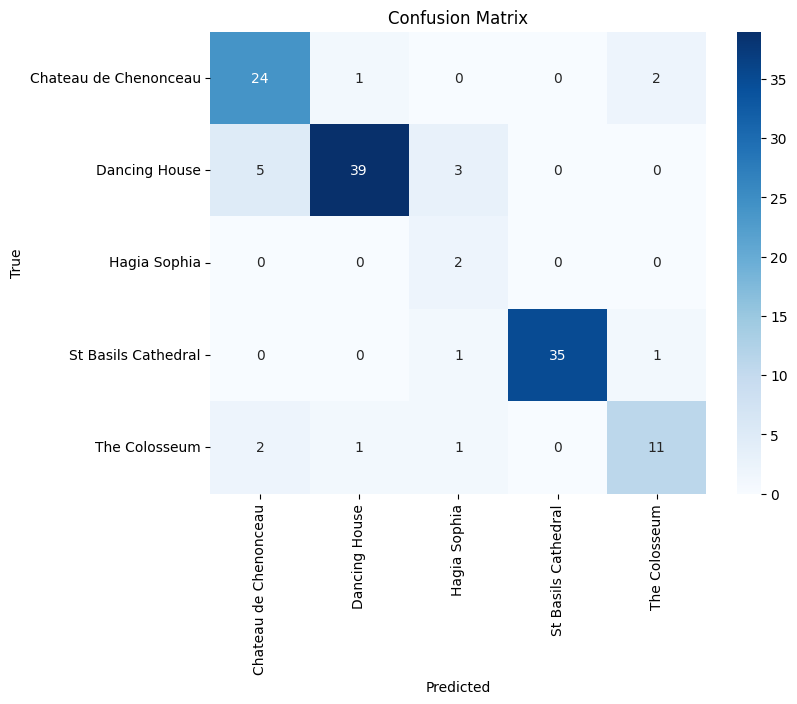

In [32]:
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[
        "Chateau de Chenonceau",
        "Dancing House",
        "Hagia Sophia",
        "St Basils Cathedral",
        "The Colosseum",
    ],
    yticklabels=[
        "Chateau de Chenonceau",
        "Dancing House",
        "Hagia Sophia",
        "St Basils Cathedral",
        "The Colosseum",
    ],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [35]:
# img = cv2.imread("st5.jpg")
# image_resized = tf.image.resize(img,(256,256))

# print(np.expand_dims(image_resized/255,0).shape)
# yhat = model.predict(np.expand_dims(image_resized/255,0))
# print(yhat)

# class_index = yhat.argmax(axis=1)
# if class_index == 0:
#     print("Chateau de Chenonceau")
# elif class_index == 1:
#     print("Dancing House")
# elif class_index == 2:
#     print("Hagia Sophia")
# elif class_index == 3:
#     print("St Basils Cathedral")
# elif class_index == 4:
#     print("The Colosseum")

# plt.imshow(image_resized.numpy().astype(int))
# plt.show()


1/1 [==============================] - 0s 31ms/step


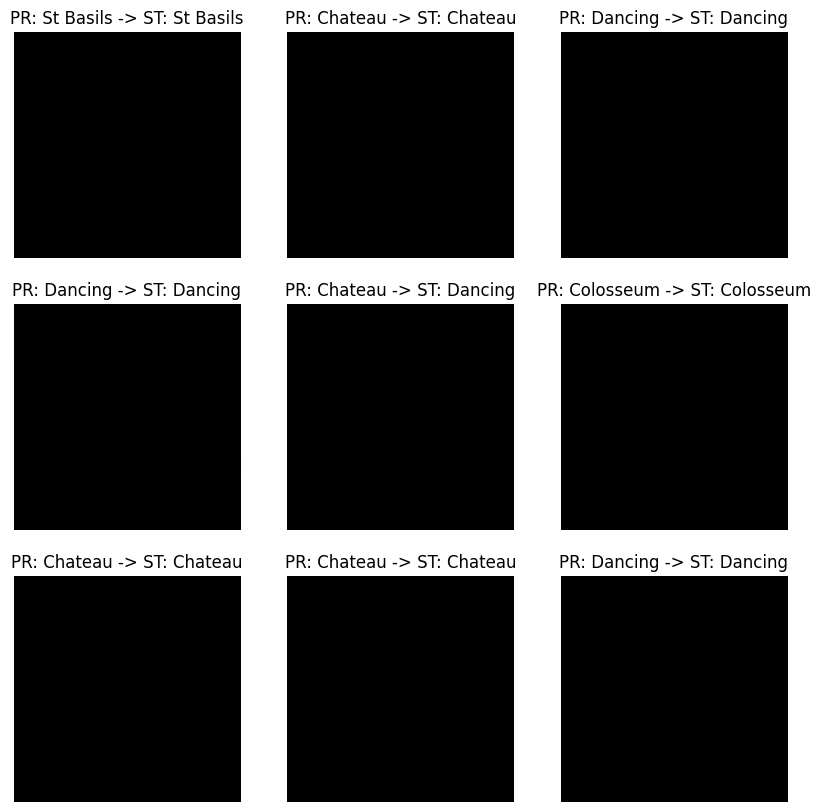

In [36]:
# test ds ne sme biti normalizovan!
class_names = ["Chateau", "Dancing", "Hagia", "St Basils", "Colosseum"]
plt.figure(figsize=(10, 10))
for images, labels in test_ds_balanced.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(model.predict(np.expand_dims(images[i],0))) #
        plt.title(f"PR: {class_names[int(label_index)]} -> ST: {class_names[np.argmax(labels[i].numpy())]}")  
        plt.axis("off")

In [37]:
# TSNE implementacija
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
import tensorflow as tf

In [38]:
# load dataset
# data = tf.keras.utils.image_dataset_from_directory(
#     "images",
#     labels="inferred",
#     label_mode="categorical",
#     image_size=(256, 256),
#     batch_size=32,   
# )

# Initialize lists to store features and targets
features = []
targets = []

# Iterate through the dataset to collect features and targets
for batch_features, batch_targets in data:
    features.extend(batch_features.numpy())
    targets.extend(batch_targets.numpy())

# Convert the lists to numpy arrays
features = np.array(features)
targets = np.array(targets)
targets = targets.astype(int)




In [39]:
features = features.reshape(features.shape[0],-1)
features.shape

(628, 196608)

In [40]:
# dimensionality reduction using t-SNE
tsne = manifold.TSNE(
    n_components=2,
)
# fit and transform
mnist_tr = tsne.fit_transform(features)
# transformed_data is a 2D numpy array of shape (30000, 2)

In [41]:
targets = np.argmax(targets, axis=1)

In [42]:
mnist_tr.shape
targets.shape

(628,)

In [43]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((mnist_tr, 
                                            targets)))
# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.head()

,CP1,CP2,target
0,1.076859,-7.176176,4.0
1,9.020468,-6.805596,2.0
2,2.249545,-7.728532,3.0
3,-0.809257,-16.352463,1.0
4,5.792983,10.427959,4.0


In [44]:
buildings_map = {
    0: "Chateau",
    1: "Dancing",
    2: "Hagia",
    3: "St Basils",
    4: "The Colosseum",
}
# map targets to actual clothes for plotting
cps_df.loc[:, "target"] = cps_df.target.map(buildings_map)

<Axes: xlabel='target'>

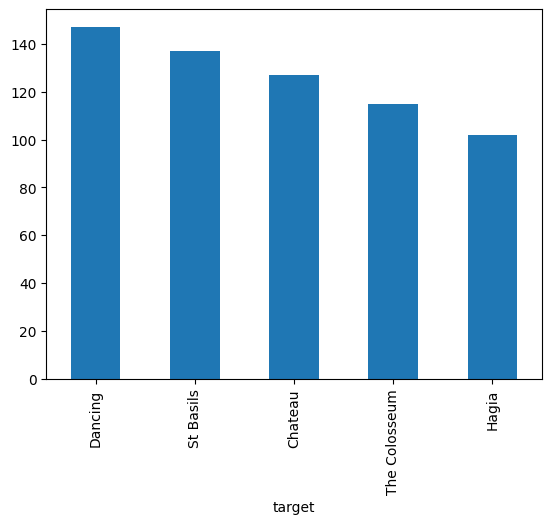

In [45]:
cps_df.target.value_counts().plot(kind='bar')

c:\Users\Nikola\Desktop\klasifikacijaSpomenika\gradjevineEnv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikola\Desktop\klasifikacijaSpomenika\gradjevineEnv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikola\Desktop\klasifikacijaSpomenika\gradjevineEnv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


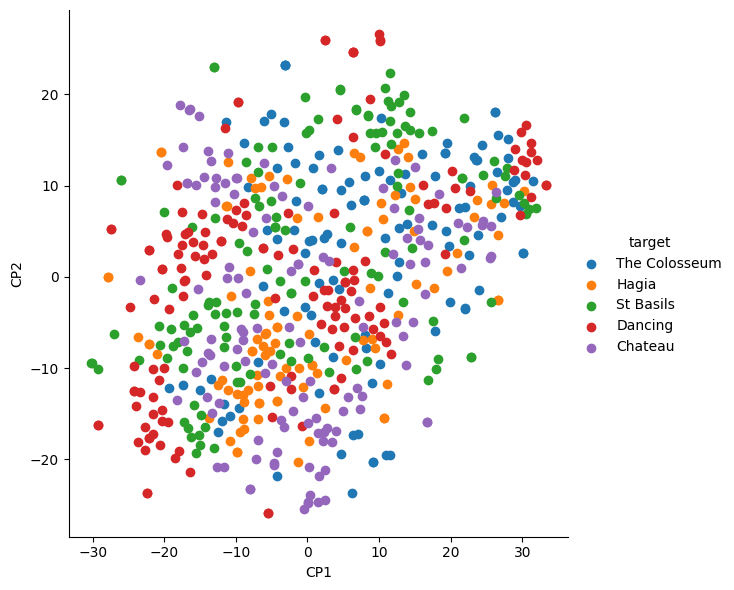

In [46]:
grid = sns.FacetGrid(cps_df, hue="target", height=6)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()